# SuperKEKB Lattice Troubleshooting

Author(s):      John Salvesen, based on code from Giovani Iadarola
Created:        22/04/2024
Last Edited:    22/04/2024

## Python Setup

### Packages

In [1]:
%matplotlib widget

import json
import numpy as np
import xtrack as xt
import xplt
import matplotlib.pyplot as plt
import pandas as pd

### User Variables

In [2]:
fname               = 'sler_1705_60_06_cw50_4b.json'
twiss_fname         = 'sler_1705_60_06_cw50_4b.twiss.json'
survey_fname        = 'sler_1705_60_06_cw50_4b.dispg.json'
ref_particle_p0c    = 4e9

## Convert SAD to XTrack Elements

### Open SAD file and build dict

In [3]:
with open("json/" + fname, 'r', encoding="utf-8") as parsed_sad:
    d = json.load(parsed_sad)

imported_elems = {}

In [4]:
sad_element_types = {}
for key in d.keys():
    if key =='line':
        continue
    sad_element_types[key] = list(d[key].keys())
sad_element_types = [(key, value) for key, values in sad_element_types.items() for value in values]
sad_element_types = pd.DataFrame(sad_element_types, columns=['SAD_element_type', 'name'])

### Drifts

In [5]:
drifts = d['drift']
for nn, vv in drifts.items():
    assert len(vv.keys()) == 1
    imported_elems[nn] = xt.Drift(length=vv['l'])

### Bends

In [6]:
bends = d['bend']
bends_off = []
bends_on = []
for nn, vv in bends.items():
    if vv['angle'] == 0:
        bends_off.append(nn)
    else:
        bends_on.append(nn)

for nn in bends_off:
    vv = bends[nn]
    if 'l' in vv:
        imported_elems[nn] = xt.Drift(length=vv['l'])
    else:
        imported_elems[nn] = xt.Marker()

for nn in bends_on:
    vv = bends[nn]

    length = vv['l']
    angle = vv['angle']
    h = angle / length
    k0 = h

    oo = []
    oo.append(
        xt.Bend(
            k0=k0,
            h=h,
            length=length,
            rot_s_rad=np.deg2rad(vv.get('rotate',0)),
            edge_entry_angle=vv.get('e1', 0)*angle, 
            edge_exit_angle=vv.get('e2', 0)*angle, 
            edge_entry_fint=1/6,
            edge_exit_fint=1/6
    ))
    imported_elems[nn] = oo

### Quadrupoles

In [7]:
for nn, vv in d['quad'].items():
    imported_elems[nn] = xt.Quadrupole(length=vv['l'], k1=vv['k1']/vv['l'], rot_s_rad=np.deg2rad(vv.get('rotate',0)))
    # TODO: neglecting fringes for now

### Multipoles

In [8]:
for nn, vv in d['mult'].items():
    # TODO neglecting multipoles for now
    imported_elems[nn] = xt.Drift(length=vv.get('l', 0))

### Octupoles

In [9]:
for nn, vv in d['oct'].items():
    assert 'l' not in vv
    # TODO neglecting octupoles for now
    imported_elems[nn] = xt.Marker()

### Cavities

In [10]:
for nn, vv in d['cavi'].items():
    assert 'l' not in vv
    # TODO neglecting cavities for now
    imported_elems[nn] = xt.Marker()

### Monitors

In [11]:
for nn, vv in d['moni'].items():
    assert 'l' not in vv
    imported_elems[nn] = xt.Marker()

### Markers

In [12]:
for nn, vv in d['mark'].items():
    assert 'l' not in vv
    imported_elems[nn] = xt.Marker()

### Apertures

In [13]:
for nn, vv in d['apert'].items():
    assert 'l' not in vv
    imported_elems[nn] = xt.Marker()

### Solenoid

In [14]:
if 'sol' in d:
    for nn, vv in d['sol'].items():
        assert 'l' not in vv
        # TODO neglecting solenoids for now
        imported_elems[nn] = xt.Marker()

### Beam Beam

In [15]:
if 'beambeam' in d:
    for nn, vv in d['beambeam'].items():
        assert 'l' not in vv
        # TODO neglecting beambeam for now
        imported_elems[nn] = xt.Marker()

## Correct Converted Elements

In [16]:
element_names = []
elements = []
element_counts = {}
for nn in d['line']:
    if nn.startswith('-'):
        inverted = True
        nn = nn[1:]
    else:
        inverted = False

    if nn not in element_counts:
        element_counts[nn] = 1
    else:
        element_counts[nn] += 1

    if element_counts[nn] == 0:
        xs_name = nn
    else:
        xs_name = nn + '.' + str(element_counts[nn])

    to_insert = imported_elems[nn]

    if inverted:
        to_insert_inverted = []
        if not isinstance(to_insert, list):
            to_insert = [to_insert]
        for ee in to_insert:
            assert isinstance(ee, (xt.Drift, xt.Marker, xt.Bend, xt.Quadrupole,
                                      xt.SRotation, xt.DipoleEdge))
            if isinstance(ee, xt.Bend):
                ee = ee.copy()
                # ee.h *= -1
                # ee.k0 *= -1
            elif isinstance(ee, xt.DipoleEdge):
                raise ValueError
                ee = ee.copy()
                # ee.k *= -1
                # ee.e1 *= -1
                # ee.side = 'entry' if ee.side == 'exit' else 'exit'
            # elif isinstance(ee, xt.Quadrupole):
            #     ee = ee.copy()
            #     ee.k1 *= -1
            elif isinstance(ee, xt.SRotation):
                raise ValueError
                ee = ee.copy()
                ee.angle *= -1
            to_insert_inverted.append(ee)

        to_insert = to_insert_inverted
        if len(to_insert) == 1:
            to_insert = to_insert[0]

    if isinstance(to_insert, list):
        for iee, ee in enumerate(to_insert):
            elements.append(ee.copy())
            element_names.append(xs_name + ':' + str(iee))
    else:
        elements.append(to_insert.copy())
        element_names.append(xs_name)

## Create XTrack Line

In [17]:
line = xt.Line(elements=elements, element_names=element_names)
line.particle_ref = xt.Particles(p0c=ref_particle_p0c, mass0=xt.ELECTRON_MASS_EV)

### Build Tracker

In [18]:
line.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


## SAD Twiss and Survey

### Survey

In [19]:
with open(f'json/{survey_fname}', 'r') as f:
    sv_sad = json.load(f)
sv_sad = pd.DataFrame(sv_sad)

### Twiss

In [20]:
with open("json/" + twiss_fname, 'r', encoding="utf-8") as f:
    tw_dict = json.load(f)

tw_dict['Element'] = np.array([nn.lower() for nn in tw_dict['Element']])

tw_sad = xt.Table(
        {
            'name': np.array(tw_dict['Element']),
            's':    np.array(tw_dict['s(m)']),
            'betx': np.array(tw_dict['BX']),
            'alfx': np.array(tw_dict['AX']),
            'bety': np.array(tw_dict['BY']),
            'alfy': np.array(tw_dict['AY']),
            'mux':  np.array(tw_dict['NX']),
            'muy':  np.array(tw_dict['NY']),
            'dx':   np.array(tw_dict['EX']),
            'dy':   np.array(tw_dict['EY']),
            'dpx':  np.array(tw_dict['EPX']),
            'dpy':  np.array(tw_dict['EPY']),
        })

tt = line.get_table()
elems_in_common = np.intersect1d(tw_sad['name'], tt.name)

tt_common = tt.rows[elems_in_common]
tsad_common = tw_sad.rows[elems_in_common]

## XSuite Twiss and Survey

### Survey

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


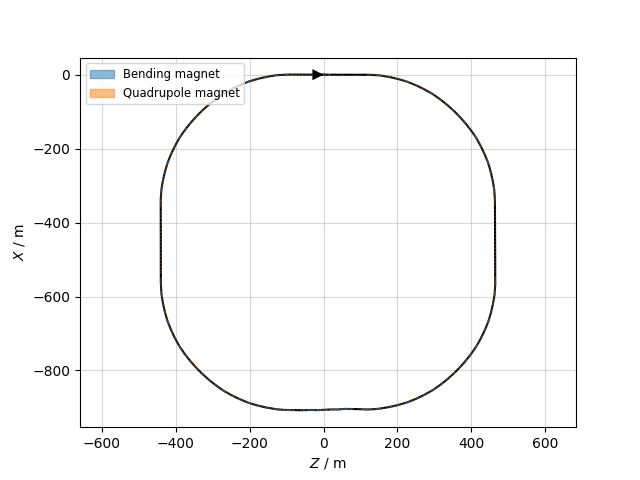

In [21]:
sv_xs = line.survey()
xplt.FloorPlot(sv_xs, line)
plt.legend(fontsize='small', loc='upper left')
plt.show()

In [35]:
print(sv_xs[])

SurveyTable: 8095 rows, 11 cols
name                   X            Y         Z        theta          phi          psi       s ...
pfbmon1.1              0            0         0            0            0            0       0
lv3p.1                 0            0         0            0            0            0       0
bv2p.1:0               0            0     0.718            0            0            0   0.718
lvb1.1       4.80057e-19  -0.00783992   2.11797  6.85831e-19      -0.0112  3.84069e-21   2.118
bv1p.1:0     1.95802e-18   -0.0319768   4.27296  6.85831e-19      -0.0112  3.84069e-21 4.27313
lvb2.1       2.43807e-18   -0.0398168   5.67293  7.10247e-35 -1.04166e-19  4.48418e-33 5.67313
pmid.1       2.43807e-18   -0.0398168   9.57293  7.10247e-35 -1.04166e-19  4.48418e-33 9.57313
lvb2.2       2.43807e-18   -0.0398168   9.57293  7.10247e-35 -1.04166e-19  4.48418e-33 9.57313
bv1p.2       2.43807e-18   -0.0398168   13.4729  7.10247e-35 -1.04166e-19  4.48418e-33 13.4731
lvb1.2       1

### Twiss

In [22]:
tw_xs = line.twiss(
    _continue_if_lost   = True,
    start               = line.element_names[0],
    end                 = line.element_names[-1],
    init                = xt.TwissInit(betx=tw_sad['betx'][0],
    alfx                = tw_sad['alfx'][0],
    bety                = tw_sad['bety'][0],
    alfy                = tw_sad['alfy'][0],
    dx                  = tw_sad['dx'][0],
    dy                  = tw_sad['dy'][0],
    dpx                 = tw_sad['dpx'][0],
    dpy                 = tw_sad['dpy'][0])
)

betx_sad = np.interp(tw_xs.s, tw_sad.s, tw_sad.betx)
bety_sad = np.interp(tw_xs.s, tw_sad.s, tw_sad.bety)

Found suitable prebuilt kernel `default_only_xtrack`.


## Plots

In [61]:
print(max(sv_xs['s']))
print(max(sv_sad['s']))

3016.306491213057
3016.306499


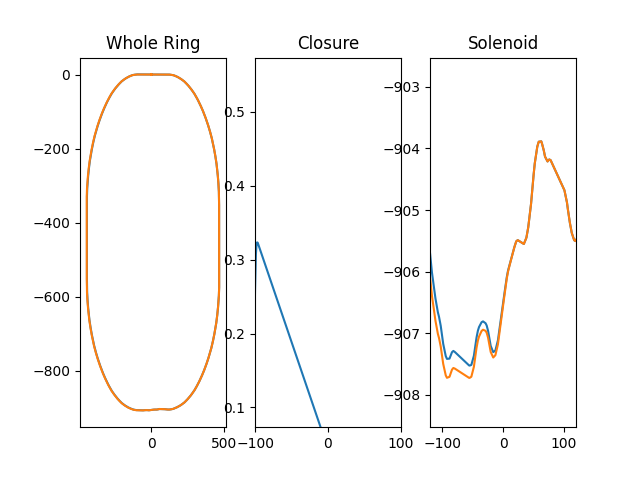

In [23]:
fig, axs = plt.subplots(1, 3)

axs[0].plot(sv_xs.Z, sv_xs.X, label='XSuite')
axs[0].plot(sv_sad['Gx'], -np.array(sv_sad['Gy']), label='sad')
axs[0].set_title('Whole Ring')

axs[1].plot(sv_xs.Z, sv_xs.X)
axs[1].plot(sv_sad['Gx'], -np.array(sv_sad['Gy']))
axs[1].set_xlim(-100, 100)
axs[1].set_ylim(max(sv_xs.X) - 0.25, max(sv_xs.X) + 0.25)
axs[1].set_title('Closure')

axs[2].plot(sv_xs.Z, sv_xs.X)
axs[2].plot(sv_sad['Gx'], -np.array(sv_sad['Gy']))
axs[2].set_xlim(-120, 120)
axs[2].set_ylim(min(sv_xs.X) - 1, min(sv_xs.X) + 5)
axs[2].set_title('Solenoid')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

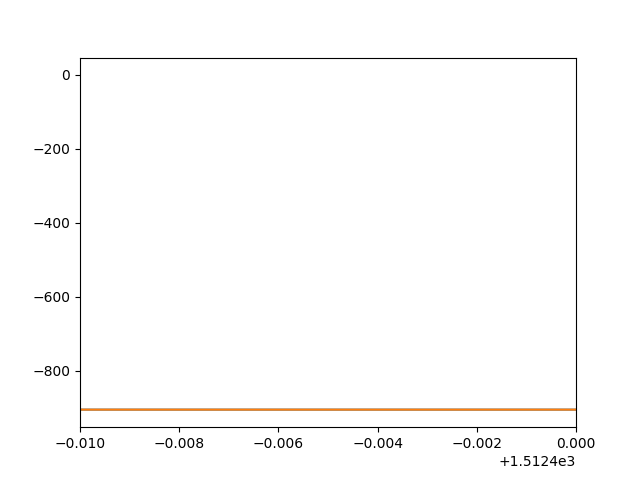

In [52]:
plt.figure()
plt.plot(sv_xs.s, sv_xs.X, label='XSuite')
plt.plot(sv_sad['s'], -np.array(sv_sad['Gy']), label='sad')
plt.xlim(1512.39, 1512.4)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

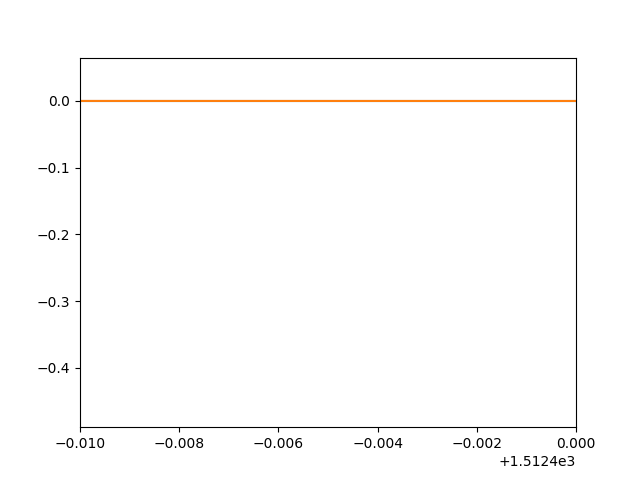

In [54]:
plt.figure()
plt.plot(sv_xs.s, sv_xs.Y, label='XSuite')
plt.plot(sv_sad['s'], -np.array(sv_sad['Gz']), label='sad')
plt.xlim(1512.39, 1512.4)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

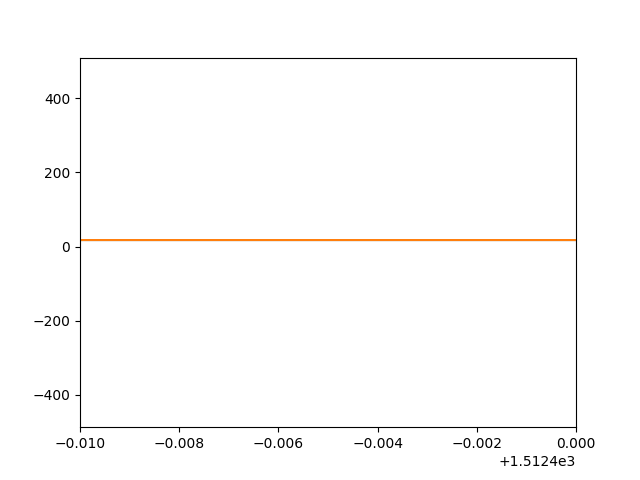

In [56]:
plt.figure()
plt.plot(sv_xs.s, sv_xs.Z, label='XSuite')
plt.plot(sv_sad['s'], np.array(sv_sad['Gx']), label='sad')
plt.xlim(1512.39, 1512.4)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

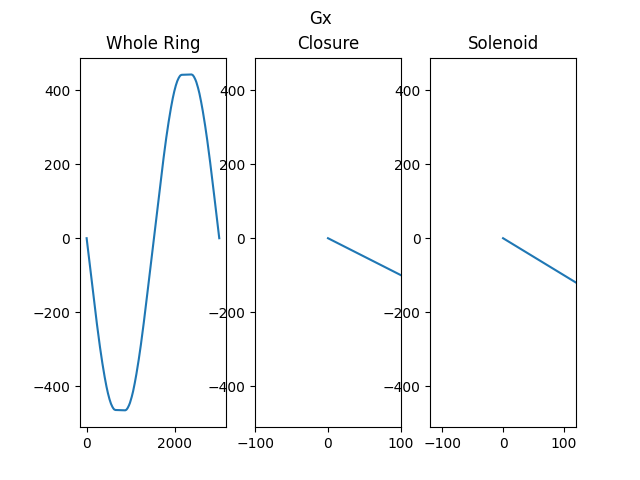

In [24]:
fig, axs = plt.subplots(1, 3)

fig.suptitle('Gx')

axs[0].plot(sv_sad['s'], -np.array(sv_sad['Gx']), label='sad')
axs[0].set_title('Whole Ring')

axs[1].plot(sv_sad['s'], -np.array(sv_sad['Gx']))
axs[1].set_xlim(-100, 100)
axs[1].set_title('Closure')

axs[2].plot(sv_sad['s'], -np.array(sv_sad['Gx']))
axs[2].set_xlim(-120, 120)
axs[2].set_title('Solenoid')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

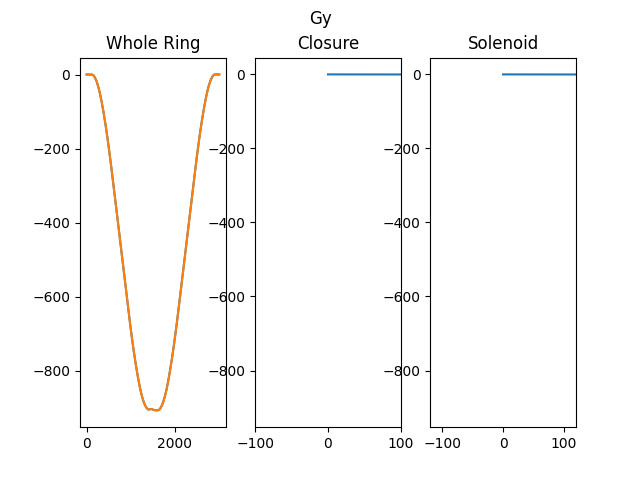

In [25]:
fig, axs = plt.subplots(1, 3)

fig.suptitle('Gy')

axs[0].plot(sv_xs.s, sv_xs.X, label='XSuite')
axs[0].plot(sv_sad['s'], -np.array(sv_sad['Gy']), label='sad')
axs[0].set_title('Whole Ring')

axs[1].plot(sv_sad['s'], -np.array(sv_sad['Gy']))
axs[1].set_xlim(-100, 100)
axs[1].set_title('Closure')

axs[2].plot(sv_sad['s'], -np.array(sv_sad['Gy']))
axs[2].set_xlim(-120, 120)
axs[2].set_title('Solenoid')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

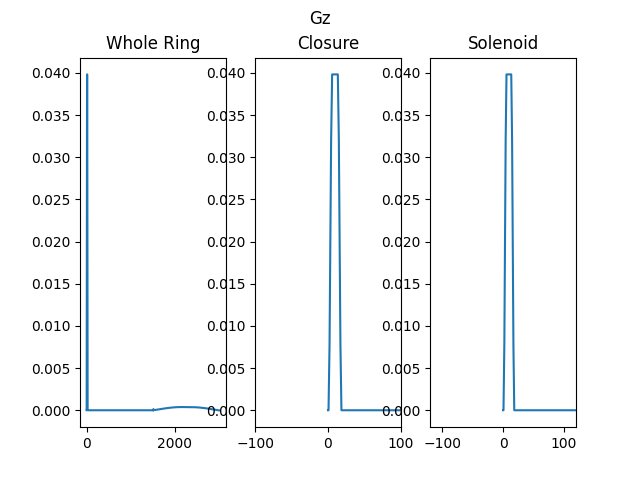

In [26]:
fig, axs = plt.subplots(1, 3)

fig.suptitle('Gz')

axs[0].plot(sv_sad['s'], -np.array(sv_sad['Gz']), label='sad')
axs[0].set_title('Whole Ring')

axs[1].plot(sv_sad['s'], -np.array(sv_sad['Gz']))
axs[1].set_xlim(-100, 100)
axs[1].set_title('Closure')

axs[2].plot(sv_sad['s'], -np.array(sv_sad['Gz']))
axs[2].set_xlim(-120, 120)
axs[2].set_title('Solenoid')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

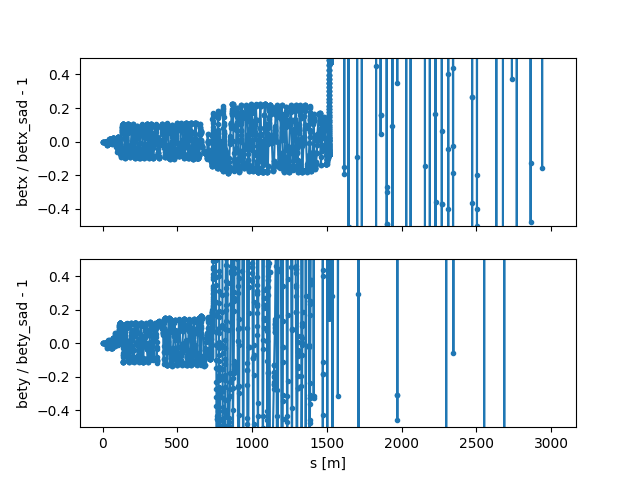

In [27]:
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].plot(tw_xs.s, tw_xs.betx / betx_sad - 1, '.-', label='x')
axs[0].set_ylim(-0.5, 0.5)
axs[0].set_ylabel('betx / betx_sad - 1')

axs[1].plot(tw_xs.s, tw_xs.bety / bety_sad - 1, '.-', label='y')
axs[1].set_xlabel('s [m]')
axs[1].set_ylabel('bety / bety_sad - 1')
axs[1].set_ylim(-0.5, 0.5)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

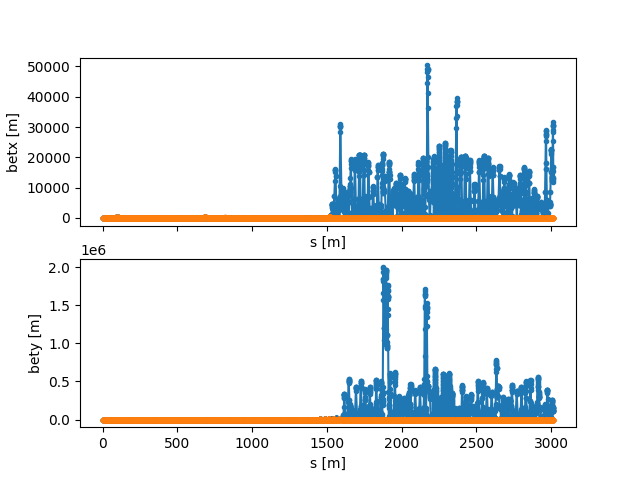

In [28]:
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].plot(tw_xs.s, tw_xs.betx, '.-', label='x, xsuite')
axs[0].plot(tw_xs.s, betx_sad, '.-', label='x, sad')
axs[0].set_xlabel('s [m]')
axs[0].set_ylabel('betx [m]')

axs[1].plot(tw_xs.s, tw_xs.bety, '.-', label='y, xsuite')
axs[1].plot(tw_xs.s, bety_sad, '.-', label='y, sad')
axs[1].set_xlabel('s [m]')
axs[1].set_ylabel('bety [m]')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

## Sad Table

In [29]:
xs_table    = line.get_table().to_pandas()

In [30]:
sad_table   = tw_sad.to_pandas()
valid_names = sad_element_types['name'].values


def clean_name(name):
    matched_name = None
    for valid_name in valid_names:
        if valid_name in name:
            if matched_name is None or len(valid_name) > len(matched_name):
                matched_name = valid_name
    return matched_name

sad_table['clean_name'] = sad_table['name'].apply(clean_name)
sad_element_types['clean_name'] = sad_element_types['name'].apply(clean_name)
sad_element_types.drop('name', axis=1, inplace=True)

sad_table = pd.merge(sad_table, sad_element_types, on='clean_name', how='left')
sad_table.drop('clean_name', axis=1, inplace=True)

In [31]:
print(sad_table[(sad_table['s'] > 118)][['s', 'name', 'SAD_element_type']])

                s        name SAD_element_type
177    118.323426      pfujlm             mark
178    118.323426      bswflp             bend
179    118.754926        lxbs            drift
180    119.195747    bs2flp.1             bend
181    120.089237   lxbsfl1.1            drift
...           ...         ...              ...
8090  3014.814100      qv1p.2             quad
8091  3015.274880  lx097b.127            drift
8092  3015.372290     zvqv1p1             bend
8093  3015.716690      lv4p.2            drift
8094  3016.306490         $$$              NaN

[7918 rows x 3 columns]


In [32]:
print(xs_table[(xs_table['s'] > 118)][['s', 'name', 'element_type']])

                s        name element_type
177    118.323426    pfujlm.1       Marker
178    118.323426  bswflp.1:0         Bend
179    118.754926      lxbs.1        Drift
180    119.195747  bs2flp.1:0         Bend
181    120.089237   lxbsfl1.1        Drift
...           ...         ...          ...
8090  3014.814101      qv1p.2   Quadrupole
8091  3015.274881  lx097b.127        Drift
8092  3015.372291   zvqv1p1.1        Drift
8093  3015.716691      lv4p.2        Drift
8094  3016.306491  _end_point             

[7918 rows x 3 columns]


In [33]:
print(d['bend']['bswflp'])

{'l': 0.4315, 'angle': -0.005036943051, 'e1': 0.5, 'e2': 0.5, 'f1': 0.2224, 'fringe': 1}


In [34]:
line['bswflp.1:0']

Bend(length=0.431, k0=-0.0117, k1=0, h=-0.0117, model='adaptive', knl=array([0., 0., 0., 0., 0.]), ksl=array([0., 0., 0., 0., 0.]), edge_entry_active=1, edge_exit_active=1, edge_entry_model='linear', edge_exit_model='linear', edge_entry_angle=-0.00252, edge_exit_angle=-0.00252, edge_entry_angle_fdown=0, edge_exit_angle_fdown=0, edge_entry_fint=0.167, edge_exit_fint=0.167, edge_entry_hgap=0, edge_exit_hgap=0, shift_x=0, shift_y=0, rot_s_rad=0)

## Solenoid Issue

In [48]:
print(sad_table[(sad_table['s'] > 1512.397) & (sad_table['s'] < 1512.4)][['s', 'name', 'SAD_element_type']])



               s       name SAD_element_type
2776  1512.39705       pirr             mark
2777  1512.39705   esrp4000              sol
2778  1512.39705  ecsrp3995             mult


In [47]:
print(sad_table[(sad_table['name'] == 'pfzlfbk1')])

        name          s     betx     alfx     bety     alfy      mux      muy  \
36  pfzlfbk1  28.764381  7.53765 -0.13191  12.1247  2.46005  0.21433  0.31694   

          dx       dy       dpx       dpy SAD_element_type  
36  0.000376  0.00006 -0.000011 -0.000019             mark  
